In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from docplex.mp.model import Model
from docplex.mp.linear import LinearExpr
import import_ipynb
import numpy as np
import Methods as mt
sns.set_theme()
%matplotlib inline

importing Jupyter notebook from Methods.ipynb


In [14]:
pontos = pd.read_csv("n_200",index_col=0)
#Número de hospitais
H = 5
#Número de veículos
K = 30
#Número de Ocorrências
O = 10

In [15]:
#Pontos escolhidos como hospitais
hospitais = pd.Series(pontos.index[np.random.randint(0,len(pontos),H)])
#Instância dos Veículos
veiculos = pd.DataFrame(index=range(K),columns=["Inicial","LowerBound","UpperBound"])

for i in veiculos.index:
    #Ponto inicial do veículo, escolhido aleatoriamente
    inicial = hospitais.loc[np.random.randint(0,len(hospitais))]
    #Quantidade do mesmo tipo de veículo no mesmo hospital
    qntd = np.random.randint(1,5)
    #Para cada veículo do mesmo tipo
    for j in range(qntd):
        lb = np.random.randint(1,6)      #Temos a prioridade mínima pela qual ele atende
        ub = np.random.randint(5,11)     #e a prioridade máxima que ele consegue atender
        veiculos.loc[i+j] = [inicial,lb,ub] #Inserção do veículo na instância

#Pontos que não estejam previamente ocupados por hospitais
aux = pontos[~pontos.index.isin(hospitais.values)].index

#Instância das vítimas
vitimas = pd.DataFrame(index=range(O),columns=["Ponto","Prioridade"])
for i in range(O):
    ponto = aux[np.random.randint(0,len(aux))]
    while ponto in vitimas["Ponto"]:
        ponto = aux[np.random.randint(0,len(aux))]
    #Escolhe dentro dos pontos das ocorrências 
    vitimas.loc[i] = [ponto,np.random.randint(1,11)]

In [16]:
#Criação da Matriz de Distância
_DistanceMatrix = pd.read_csv("d_200",index_col=0)

In [17]:
#Excluimos todas as distâncias referentes
#aos arcos não existentes
for i in _DistanceMatrix.index:
    for j in _DistanceMatrix.index:
        if j not in pontos.loc[i][2:].values:
            _DistanceMatrix.loc[i][j]=0

# Modelagem - VRP

In [18]:
vrp = Model("Ambulancias-VRP") #Modelo

In [19]:
#Matriz com as variáveis de decisão principais
_DecisionCube = vrp.binary_var_cube(_DistanceMatrix.index,_DistanceMatrix.index,veiculos.index,"Arc")

In [20]:
#Função Objetivo
vrp.minimize(vrp.sum(_DecisionCube[i,j,k]*_DistanceMatrix.loc[i][j] 
                     for i in _DistanceMatrix.index 
                     for j in _DistanceMatrix.index 
                     for k in veiculos.index))

In [21]:
forbidden = LinearExpr(vrp)   #Arcos proíbidos

for k in veiculos.index:
    for i in _DistanceMatrix.index:

        flux = LinearExpr(vrp)    #Conservação de Fluxo
        match = LinearExpr(vrp)   #Restrição de Compatibilidade
        for j in _DistanceMatrix.index:

            if _DistanceMatrix.loc[i][j] > 0:    #Verifica se o arco existe

                if i in vitimas["Ponto"].values:   #Se nodo 'i' for uma vítima:
                    match+=_DecisionCube[j,i,k]    #Adiciona os arcos 'jik' em 'match'
                    flux +=_DecisionCube[j,i,k]    #Subtrai o arco de chegada em 'i'
                    forbidden+=_DecisionCube[i,j,k]#A ambulância não pode um arco saindo de 'i'

                elif i == veiculos.loc[k]["Inicial"]: #Se o nodo 'i' for um hospital
                    flux += _DecisionCube[i,j,k]      #Adiciona o arco de saída de 'i'

                elif j == veiculos.loc[k]["Inicial"]: #Se o nodo 'j' for o ponto de saida de 'k'
                    forbidden += _DecisionCube[i,j,k] #Retira o arco 'ij' da solução
                    flux -=_DecisionCube[j,i,k]       #Coloca o arco de saída de 'j' no fluxo

                else:                                 #Se nenhum desses casos se aplicar
                    flux+=_DecisionCube[i,j,k]-_DecisionCube[j,i,k] #Fluxo normal


            else:                                #Se o arco não existir
                forbidden += _DecisionCube[i,j,k]#Tira ele da solução

        if i in vitimas["Ponto"].values: #Se nodo 'i' for uma vítima
            #Permite 'k' chegar em 'i' no máximo 1 vez
            vrp.add_constraint(flux<=1,"ChegadaVitima_"+str(i)+"_Carro_"+str(k))

            #Pega a prioridade da vitima 'i'
            prioridade = vitimas[vitimas["Ponto"] == i]["Prioridade"].values[0]

            #E cria as restriçõe de UpperBound
            vrp.add_constraint((veiculos.loc[k]["UpperBound"])*match-prioridade*match>=0,
                               "MatchUB_Ocurrence_"+str(i)+"_Vehicle"+str(k))
            #E LowerBound
            vrp.add_constraint((veiculos.loc[k]["LowerBound"])*match-prioridade*match<=0,
                              "MatchLB_Ocurrence_"+str(i)+"_Vehicle"+str(k))

        elif i == veiculos.loc[k]["Inicial"]: #Se o nodo 'i' for o inicial do veiculo 'k'
            #Permite 'k' sair de 'i' no máximo 1 vez
            vrp.add_constraint(flux<=1,"FluxoInicialVeiculo_"+str(k))
        else:
            #Fluxo Normal
            vrp.add_constraint(flux==0,"Fluxo_"+str(i)+"_Carro_"+str(k))

#Eliminação dos arcos inválidos
vrp.add_constraint(forbidden==0,"Cuts");

In [22]:
for k in veiculos.index:

    inicial = veiculos.loc[k]["Inicial"] #Ponto de Saída de 'k'

    flux_inicial = LinearExpr(vrp) #Fluxo de Saída de 'k'

    for i in pontos.loc[inicial][2:].values:          #Para todos os arcos saindo do inicial
        flux_inicial+=_DecisionCube[inicial,int(i),k] #Adicione-os ao fluxo de saída

    flux_final = LinearExpr(vrp) #Fluxo de Chegada nas ocorrências

    for i in vitimas["Ponto"].values:          #Para todas as ocorrências
        for j in pontos.loc[i][2:]:            #Para todos os arcos saindo delas
            flux_final += _DecisionCube[j,i,k] #Adicione-os ao fluxo de chegada

    #Se o veículo sair de seu ponto inicial, ele deve atender uma ocorrência
    vrp.add_constraint(flux_inicial-flux_final==0,"AtendimentoObrigatorio_"+str(k))

In [23]:
for i in vitimas["Ponto"].values:

    demand = LinearExpr(vrp) #Demanda da vítima 'i'

    for j in pontos.loc[i][2:].values:
        for k in veiculos.index:
            #Para cada arco 'j' chegando em 'i' e veículo 'k'
            #Os adicionamos à expressão
            demand+=_DecisionCube[int(j),int(i),k]
    #Ao menos um precisa passar nessa vítima
    vrp.add_constraint(demand>=1,"DemandaVitima_"+str(i))


In [24]:
for k in veiculos.index:
    capacidade = LinearExpr(vrp) #Capacidade do veículo 'k'
    for i in vitimas["Ponto"].values:
        for j in pontos.loc[i][2:]:
            #Para cada arco chegando em cada vítima
            #Adicione-o à expressão
            capacidade+=_DecisionCube[int(j),int(i),k]

    #O veículo só pode 
    vrp.add_constraint(capacidade<=1,"CapacidadeVeiculo_"+str(k))

In [25]:
import time
start = time.time() #Tempo de ínicio
subcicle = True     #Condição de parada
#Assumindo que existe subciclos, nós...
while subcicle == True:

    #Rota percorrida por cada veículo
    routes = {x:{} for x in veiculos.index}    

    #Solução VRP - Dicionário Desordenado
    _Solution = vrp.solve().as_dict()
    #saida veículo
    #    |   |
    #    v   v
    #Arc_i_j_k: True/False <-Valores Possíveis
    #      ^
    #      |
    #   chegada
    #
    #Arc_i_j_k = Chave

    for i in _Solution:
        #
        #
        #"Arc_i_j_k"
        #     |   
        #     v                      0   1   2
        aux = i.split("_")[1:] #<- ["i","j","k"]
        #        ^
        #        |
        #["Arc","i","j","k"]
        #
        #         veiculo=k    saida=i      chegada=j
        #             |            |            |
        #             v            v            v
        routes[int(aux[2])][int(aux[0])]=int(aux[1])
        # ^
        # |_ Rotas agrupadas por veículo

    print(routes)
    count = 0 #Contador para as eliminações de subciclo
    summ = 0 #Condição de parada

    #O trecho de código abaixo deve remover o caminho
    #principal para futuramente verificarmos se existe
    #algum subciclo na rota do veículo 'k'
    for k in veiculos.index:

        #Primeiramente, verificamos se o veículo 'k'
        #percorreu, ou não, pelo menos um arco
        if len(routes[k]) > 0:

            #Se ele percorreu pelo menos um arco:
            #Começamos verificando qual o ponto de saida
            #do veículo 'k' e atribuímos esse nodo para
            #o ponto de partida do nosso loop

            inicial = veiculos.loc[k]["Inicial"]
            #  ^
            #  |
            #Saída de 'k'
            #
            #Chegada de 'k'
            #saindo do ponto
            #inicial
            #  |
            #  v
            actual_node = routes[k].pop(inicial)

            #inicial->actual_node = primeiro arco de todas as rotas

            #Iremos percorrer a rota até que alcançemos a vítima
            while actual_node not in vitimas["Ponto"].values:
                # actual_node                actual_node
                #vira chegada do        inicia como saída do
                #  arco                        arco
                #   |                            |
                #   v                            v
                actual_node = routes[k].pop(actual_node)

                #it0: actual_node-> nodo 'j'
                #               ^
                #               |
                #it1:     actual_node -> nodo 'k'
                #                             ^
                #                             |
                #it2:                     actual_node -> nodo 'l' ...


        #Se sobrou algum subciclo
        #depois da remoção do caminho
        #principal então 
        #len(routes[k]) > 0
        summ += len(routes[k])


        #Se sobrou algum arco dentro
        #da rota, então deve ser algum
        #subciclo que devemos retirar
        if len(routes[k]) >0:

            #Enquanto ainda existir algum arco
            #dentro da rota do veículo 'k'
            #ele faz parte de um subciclo
            #que deve ser retirado, portanto
            #iteramos até removermos todos os
            #subciclos
            while(len(routes[k])>0):
                print(routes[k])
                cut = LinearExpr(vrp) #Expressão Linear do Subciclo atual

                first_node = list(routes[k].keys())[0]
                #  ^
                #  |
                #saída do primeiro arco
                #do subciclo atual
                #
                #chegada do primeiro
                #arco do subciclo atual
                #  |
                #  v
                actual_node = routes[k].pop(first_node)

                #Adicionamos o arco inicial à restrição
                cut += _DecisionCube[int(first_node),int(actual_node),k]

                #Tamanho do subciclo -1
                size = 0
                while(actual_node != first_node):
                    next_node = routes[k].pop(actual_node)                 #Percorre o subciclo e o adiciona ao#
                    cut += _DecisionCube[int(actual_node),int(next_node),k]#conjunto de subciclos proíbidos.#
                    actual_node = next_node
                    size+=1
                count+=1
                vrp.add_constraint(cut<=size,"SubCycleCut_"+str(count))

    if summ == 0:
        subcicle = False
print(time.time()-start)


{0: {}, 1: {}, 2: {}, 3: {61: 150, 85: 134, 125: 85, 129: 157, 150: 129, 157: 125, 179: 61}, 4: {}, 5: {}, 6: {}, 7: {128: 154, 154: 28}, 8: {}, 9: {92: 51}, 10: {}, 11: {102: 193, 176: 102}, 12: {}, 13: {79: 80, 80: 41}, 14: {}, 15: {}, 16: {}, 17: {}, 18: {}, 19: {76: 53, 117: 127, 127: 76, 128: 117}, 20: {9: 196, 40: 115, 44: 119, 46: 187, 78: 160, 92: 44, 119: 136, 136: 9, 160: 46, 187: 40, 196: 78}, 21: {}, 22: {}, 23: {}, 24: {32: 111, 79: 32}, 25: {}, 26: {117: 127, 127: 163, 128: 117}, 27: {}, 28: {}, 29: {}, 30: {44: 119, 56: 62, 92: 44, 119: 56}, 31: {}}
7.906657934188843


In [28]:
#Libera Memória
del _DecisionCube
del vrp

NameError: name '_DecisionCube' is not defined

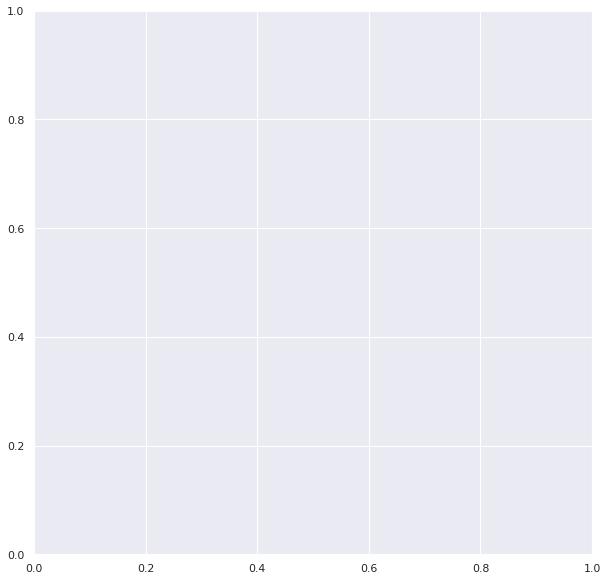

In [71]:
Figure,Axes = plt.subplots(figsize=(10,10))

In [72]:
routes = {x:{} for x in veiculos.index}  
#Cria novamente as rotas de cada veículo
for i in _Solution:
        aux = i.split("_")[1:]
        routes[int(aux[2])][int(aux[0])]=int(aux[1])
        
atendimentos = {}
arc_count = {}
for k in veiculos.index:
    #Só roda o código se o veículo tiver percorrido pelo menos um arco
    if len(routes[k]) > 0:
        
        inicial = veiculos.loc[k]["Inicial"]
        actual_node = routes[k].pop(inicial)
        
        #Coordenadas X e Y dos pontos que formam o arco
        xcoord=[pontos.loc[inicial]["x"],pontos.loc[actual_node]["x"]]
        ycoord=[pontos.loc[inicial]["y"],pontos.loc[actual_node]["y"]]
        
        #Plotagem gráfica do arco 
        Axes.scatter(xcoord[0],ycoord[0],s=30,color='red',zorder=1)
        #Axes.text(xcoord[0],ycoord[0],str(inicial),fontsize=12,color="red")
        Axes.plot(xcoord,ycoord,'g',zorder=0)
        
        #String para plotar o caminho que o carro percorreu
        string=str(k)+": "+str(inicial)+" -> "+str(actual_node)
        
        #Garante que o caminho será plotado mesmo se só tiver um arco
        if len(routes[k]) == 0:
            #Plotagem gráfica do último arco do caminho
            Axes.scatter(xcoord[1],ycoord[1],s=30,color='purple',zorder=1)
            #Axes.text(xcoord[1],ycoord[1],str(actual_node),fontsize=12,color="purple")
        else:
            while actual_node not in vitimas["Ponto"].values:
                next_node = routes[k].pop(actual_node)

                #Adiciona um arco na string
                string+="-> "+str(next_node)

                #Coordenadas X e Y dos pontos que formam o arco
                xcoord=[pontos.loc[actual_node]["x"],pontos.loc[next_node]["x"]]
                ycoord=[pontos.loc[actual_node]["y"],pontos.loc[next_node]["y"]]
                
                #Plotagem gráfica do arco 
                Axes.scatter(xcoord[0],ycoord[0],s=20,color='black',zorder=1)
                Axes.plot(xcoord,ycoord,'g',zorder=0)
                
                actual_node=next_node
            
            #Plotagem gráfica do último arco do caminho
            Axes.scatter(xcoord[1],ycoord[1],s=20,color='purple',zorder=1)
            #Axes.text(xcoord[1],ycoord[1],str(next_node),fontsize=12,color='purple')
            
        atendimentos[k] = actual_node
        print(string)

3: 179 -> 61-> 150-> 129-> 157-> 125-> 85-> 134
7: 128 -> 154-> 28
9: 92 -> 51
11: 176 -> 102-> 193
13: 79 -> 80-> 41
19: 128 -> 117-> 127-> 76-> 53
20: 92 -> 44-> 119-> 136-> 9-> 196-> 78-> 160-> 46-> 187-> 40-> 115
24: 79 -> 32-> 111
26: 128 -> 117-> 127-> 163
30: 92 -> 44-> 119-> 56-> 62


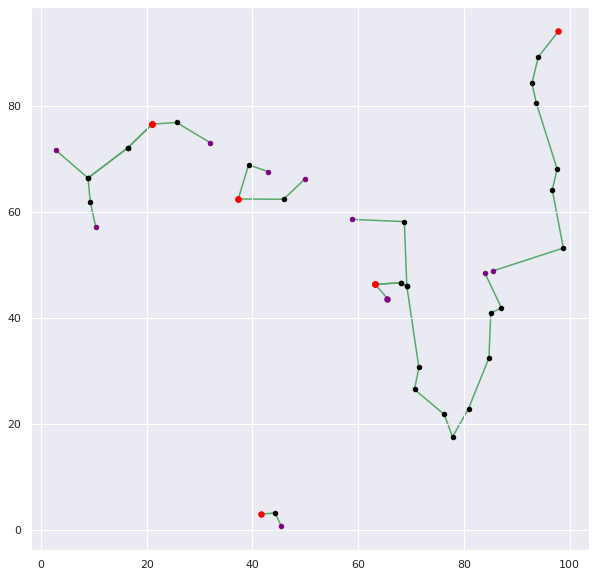

In [73]:
Figure

# Sinais

In [32]:
estado = pd.read_csv("s_200",index_col=0)

In [33]:
sinais = Model("Sinais")

In [34]:
sinal = 0 #Tempo entre as alterações de estado de um sinal
for i in pontos.index:
    for j in pontos.loc[i][2:]:
        #Somamos o tempo de cada arco
        sinal+=_DistanceMatrix.loc[i][int(j)]
sinal = (sinal/(3*len(pontos))) #O tempo de alteração vai ser a média

In [35]:
ordered_routes = mt.DecomposeRoute(_Solution,veiculos,vitimas) #Organiza os caminhos por ambulância
arc_count = mt.makeArcCount(ordered_routes,_DistanceMatrix) #Arcos usados na solução e a quantidade de usos

In [36]:
#Maior Instante em todos os cenários
#Usado para criar apenas a quantidade
#necessária de variáveis sem desperdiçar memória
maior_instante = 0

#Matriz contendo todas as configurações
#de sinais para cada veículo e sua rota
matriz_rotas={k:[] for k in atendimentos}


for k in atendimentos:
    #                                        Nodo da 
    #                         Nodos de        vítima        pd.Series
    #           Prioridade    todas as       atendida    com a prioridade
    #            em si        vítimas         por 'k'       da vítima
    #             |              |              |              | 
    #             v              v              v              v           
    prioridade=vitimas[vitimas["Ponto"]==atendimentos[k]]["Prioridade"].values[0]
    
    matriz,instante=  mt.buildSets(_DistanceMatrix,    #Matriz de Distância
                                 ordered_routes[k],  #Rotas por veículo
                                 sinal,              #Tempo de alteração do sinal
                                 prioridade,         #Prioridade da vítima atendida por 'k'
                                 pontos,             #DataFrame com os pontos e arcos
                                 estado,             #DataFrame com os estados dos sinais
                                 arcos_fixos={},     #Arcos já fixados anteriormente
                                 sinais_alterados=[],#Uso interno, instanciar como lista vazia
                                 matriz_sinais=[])   #Uso interno, instanciar como lista vazia
    #Guarda o maior instante
    #encontrado até o momento
    if instante>maior_instante:
        maior_instante=instante
    
    #Adiciona as configurações
    #possíveis para a rota do
    #veículo 'k' para a matriz
    matriz_rotas[k] = matriz

In [37]:
#Dicionário para guardar os
#veículos que passam no mesmo
#arco no mesmo instante
same_instant={}

for arc in arc_count:
    #Adiciona o arco atual
    #no dicionário
    same_instant[arc]={}
    
    #Dicionário de instantes
    #separado por veículo
    instants={}
    for k in atendimentos:
        #                         Índice
        #                     da configuração
        #                           |
        #                           | Arcos percorridos
        # (x,y)             Veículo |       por 'k'
        #   |                  |    /   _____|______
        #   v                  v   v   |            |
        if arc in matriz_rotas[k][0]["sinais"].keys():#'k' passa em (x,y)?
            #Contador do índice das
            #configurações dos sinais
            count = 0
            
            #Variedade de instantes
            #em que 'k' pode passar
            #em (x,y) de acordo com
            #a configuração que o 
            #modelo escolher
            instants[arc]=[]
            
            #Percorre todas as configurações
            #de sinais para a rota de 'k'
            while count < len(matriz_rotas[k]):
                #                         Índice da           Instante
                #                        Configuração             |
                #                             |  Configuração     |
                #                     Veículo |       |     (x,y) |
                #                        |    |       |       |   |
                #                        v    v       v       v   v
                instant_k = matriz_rotas[k][count]["sinais"][arc][1]#Quando 'k' passa em (x,y)?

                #Verificamos se o instante atual ainda não
                #está listado nos instantes em que um dos
                #veículos passa em (x,y)
                if round(instant_k) not in instants[arc]:
                    
                    #Quando for a primeira vez que um veículo
                    #passa em (x,y), adicionamos esse instante
                    #na lista
                    instants[arc].append(round(instant_k))
                    
                    #Quando for a primeira vez que um veículo
                    #passa em (x,y) nesse instante, criamos a
                    #lista no nosso dicionário, usamos o instante
                    #arredondado para baixo como chave e uma tupla
                    #(Veículo,ìndice da Configuração) como valor
                    same_instant[arc][round(instant_k)]=[(k,count)]
                    
                else:
                    #Quando uma nova configuração for encontrada na qual
                    #um veículo passe em (x,y) no mesmo instante, adicionamos
                    #a tupla (Veículo,ìndice da Configuração) no dicionário
                    same_instant[arc][round(instant_k)].append((k,count))
                    #NOTA IMPORTANTE:
                    #
                    #Arredondamos o instante para o inteiro
                    #mais próximo para evitar inconsistências.
                    #Uma vez que se ambos estiverem no arco durante
                    #o mesmo intervalo, os dois se beneficiarão da
                    #alteração ou não alteração do sinal.
                    #
                    #Por exemplo:
                    #   Veículo1 está em (x,y) no instante 7.2
                    #   Veículo2 está em (x,y) no instante 7.31
                    #
                    #      7.2                     7.31
                    #   instante_k Veículo1 != instante_k Veículo2
                    #
                    #           7                           7
                    #    _______|______              _______|______
                    #   |              |            |              |   
                    #   round(instant_k) Veículo == round(instant_k) Veículo2
                count+=1

In [38]:
#Dicionário onde guardaremos
#todas as variáveis do modelo
config = {}

#Nos preocupamos apenas com os
#veículos que saíram para realizar 
#algum atendimento
for k in atendimentos:
    
    #Contador do índice
    #das configurações
    count=0
    
    #Lista das possíveis configurações
    #de sinais para o veículo 'k'
    config[k]=[]
    
    for i in matriz_rotas[k]:
        #                                                         Índice           Veículo    Peso da Configuração
        #                                                           |                 |                | 
        #                                                           v                 v                v 
        config[k].append({"Config":sinais.binary_var("Config_"+str(count)+"_Carro_"+str(k)),"Peso":i["peso"]})
        #"Config":Variável de Decisão que representa uma configuração completa
        #"Peso": Tempo de percorrer a rota com essa configuração de sinais
        count+=1

In [39]:
#Função Objetivo
minimize=LinearExpr(sinais)

for k in atendimentos:
    #Restrição de unicidade
    choose1=LinearExpr(sinais)
    
    for i in config[k]:
        #Adiciona a configuração 
        #atual à restrição
        choose1+=i["Config"]
        
        #Adiciona o peso da configuração
        #na função objetivida para ser
        #minimizado futuramente
        minimize+=i["Config"]*i["Peso"]
        
    #Permitimos ao modelo escolher
    #apenas uma configuração para
    #cada rota percorrida
    sinais.add_constraint(choose1==1,"Choose1ConfigVehicle"+str(k))
    
sinais.minimize(minimize)

In [40]:
#Varremos todos os arcos
#no nosso dicionário
for arc in same_instant:
    
    #Precisamos verificar todos os
    #instantes em que um veículo
    #passou por esse arco
    for instant in same_instant[arc]:
        
        #Dicionário que irá conter
        #todas as expressões de
        #consistência que iremos criar
        expressions={}
        
        for i in same_instant[arc][instant]:
            #i=(Veículo,Índice da Configuração)
            vehicle = i[0]
            config_number = i[1]
            
            #Verificamos se o veículo atual
            #não está entre as chaves do nosso
            #dicionário de expressões
            if vehicle not in expressions.keys():
                #Criamos a expressão linear
                #que será usada como restrição
                expr=LinearExpr(sinais)
                
                #Inicializamos ela com a configuração atual
                expr+=config[vehicle][config_number]["Config"]
                
                #Instanciamos a chave no dicionário
                expressions[vehicle]=expr
            else:
                #Adicionaremos todas as configurações
                #do veículo 'k' que passam em (x,y)
                #no mesmo instante
                expressions[vehicle]+=config[vehicle][config_number]["Config"]
        
        #Restrição de Consistência
        consistent_timing=LinearExpr(sinais)
        #Contador Auxiliar
        count=0
        for k in expressions:
            #Consideramos o primeiro veículo como o pivô
            if count==0:
                #Todas as configurações dele são multiplicadas
                #pela quantidade de OUTROS veículos no dicionário
                consistent_timing+=(len(expressions)-1)*expressions[k]
                count+=1
            else:
                #Caso não seja nosso veículo pivô, subtraímos
                #a configuração da nossa expressão
                consistent_timing-=expressions[k]
        
        #A expressão é construída dessa forma pois,
        #caso alguma das configurações seja escolhida,
        #nós forçamos que todas as outras também o sejam
        #e, caso nenhuma seja escolhida, que nenhuma das
        #outras também o seja
        #Exemplo:
        #    k=Veículo Pivô a=b= Outros Veículos
        #   
        #    expr=2*k_0 + 2*k_1...+2*k_m 
        #         - a_0 - a_1 -...a_n
        #         - b_0 - b_1 -...b_o
        #
        #    Se k_0 = 1 e expr==0, Então:           _
        #         - a_0 - a_1 -...a_n = -1 |-Só pode escolher 
        #         - b_0 - b_1 -...b_o = -1_| uma configuração
        #
        #    Se 2*k_0 + 2*k_1...+2*k_m = 0 e expr == 0, Então
        #         - a_0 - a_1 -...a_n = 0
        #         - b_0 - b_1 -...b_o = 0
        sinais.add_constraint(consistent_timing==0,"ConsistentTimingArc_"+str(arc)+"_instant_"+str(instant))

In [41]:
_Solution2 = sinais.solve()

In [42]:
#Sinais Fixados
sinais_fixos={}

#Instantes de chegada
#na vitimas atendinda
atendimento_instantes={}

tempo_total_ida=0
relativo_ida=0
tempo_cru_ida=0
tempo_veiculos_ida = {k:{"total":0,"cru":0} for k in atendimentos}
#O código abaixo serve apenas para imprimir
#a solução em uma espécie de texto formatado
#e fixar os sinais da solução atual
for i in _Solution2.as_dict():
    carro = int(i.split("_")[3])
    config = int(i.split("_")[1])
    string1="Veículo"+str(carro)
    string2="(Sit,T)"+" "*(len(string1)-4)
    for i in matriz_rotas[int(carro)][int(config)]["sinais"]:
        string1+= "-> "+str(i)
        
        tempo_total_ida+=matriz_rotas[carro][config]["tempo"]
        tempo_cru_ida+=matriz_rotas[carro][0]["tempo"]
        relativo_ida+=matriz_rotas[carro][config]["relativo"]
        
        tempo_veiculos_ida[carro]["total"]=matriz_rotas[carro][config]["tempo"]
        tempo_veiculos_ida[carro]["cru"]=matriz_rotas[carro][0]["tempo"]
        
        alterado=matriz_rotas[carro][config]["sinais"][i][0]
        instante=round(matriz_rotas[carro][config]["sinais"][i][1])
        string2+=str((alterado,instante))+" "*(len(str(i))-3)
        sinais_fixos[i]={"alterado":alterado,"instante":instante}
    atendimento_instantes[carro]=instante
    print(string1)
    print(string2)
    print("")

Veículo3-> (179, 61)-> (61, 150)-> (150, 129)-> (129, 157)-> (157, 125)-> (125, 85)-> (85, 134)
(Sit,T)    (0, 1)      (0, 1)      (0, 1)       (0, 3)       (0, 3)       (0, 4)      (0, 6)      

Veículo7-> (128, 154)-> (154, 28)
(Sit,T)    (0, 0)       (0, 1)      

Veículo9-> (92, 51)
(Sit,T)    (0, 0)     

Veículo11-> (176, 102)-> (102, 193)
(Sit,T)     (1, 1)       (0, 2)       

Veículo13-> (79, 80)-> (80, 41)
(Sit,T)     (1, 2)     (0, 2)     

Veículo19-> (128, 117)-> (117, 127)-> (127, 76)-> (76, 53)
(Sit,T)     (0, 1)       (0, 2)       (0, 2)      (0, 2)     

Veículo20-> (92, 44)-> (44, 119)-> (119, 136)-> (136, 9)-> (9, 196)-> (196, 78)-> (78, 160)-> (160, 46)-> (46, 187)-> (187, 40)-> (40, 115)
(Sit,T)     (0, 0)     (1, 2)      (1, 4)       (1, 6)     (1, 7)     (0, 8)      (0, 8)      (1, 10)      (0, 11)      (0, 11)      (0, 12)      

Veículo24-> (79, 32)-> (32, 111)
(Sit,T)     (1, 2)     (1, 3)      

Veículo26-> (128, 117)-> (117, 127)-> (127, 163)
(Sit,T)     (1,

# VRP - Volta

In [43]:
vrp_volta = Model("Ambulancias-VRP") #Modelo

In [44]:
#Matriz com as variáveis de decisão principais
#Desta vez nos preocupamos apenas com os veículos
#que atenderam algum paciente
_DecisionCube = vrp_volta.binary_var_cube(_DistanceMatrix.index,_DistanceMatrix.index,atendimentos,"Arc")

In [45]:
#Função Objetivo
vrp_volta.minimize(vrp_volta.sum(_DecisionCube[i,j,k]*_DistanceMatrix.loc[i][j] 
                     for i in _DistanceMatrix.index 
                     for j in _DistanceMatrix.index 
                     for k in atendimentos))

In [46]:
alvos = {k:0 for k in atendimentos}

In [47]:
for k in atendimentos:
    alvos[k] = hospitais[np.random.randint(0,len(hospitais))]

In [48]:
forbidden = LinearExpr(vrp_volta)   #Arcos proíbidos

for k in atendimentos:
    for i in _DistanceMatrix.index:

        flux = LinearExpr(vrp_volta)    #Conservação de Fluxo
        for j in _DistanceMatrix.index:

            if _DistanceMatrix.loc[i][j] > 0:    #Verifica se o arco existe

                if i == alvos[k]:                  #Se nodo 'i' for uma vítima:
                    flux +=_DecisionCube[j,i,k]    #Subtrai o arco de chegada em 'i'
                    forbidden+=_DecisionCube[i,j,k]#A ambulância não pode um arco saindo de 'i'

                elif i == atendimentos[k]:            #Se o nodo 'i' for um hospital
                    flux += _DecisionCube[i,j,k]      #Adiciona o arco de saída de 'i'

                elif j == atendimentos[k]:            #Se o nodo 'j' for o ponto de saida de 'k'
                    flux -=_DecisionCube[j,i,k]
                    forbidden += _DecisionCube[i,j,k] #Retira o arco 'ij' da solução

                else:                                 #Se nenhum desses casos se aplicar
                    flux+=_DecisionCube[i,j,k]-_DecisionCube[j,i,k] #Fluxo normal
            else:                                #Se o arco não existir
                forbidden += _DecisionCube[i,j,k]#Tira ele da solução
        if i == alvos[k]: #Se nodo 'i' for uma vítima
            #Permite 'k' chegar em 'i' no máximo 1 vez
            vrp_volta.add_constraint(flux==1,"ChegadaVitima_"+str(i)+"_Carro_"+str(k))

        elif i == atendimentos[k]: #Se o nodo 'i' for o inicial do veiculo 'k'
                                    #Permite 'k' sair de 'i' no máximo 1 vez
            vrp_volta.add_constraint(flux==1,"FluxoInicialVeiculo_"+str(k))
        else:
            #Fluxo Normal
            vrp_volta.add_constraint(flux==0,"Fluxo_"+str(i)+"_Carro_"+str(k))

#Eliminação dos arcos inválidos
vrp_volta.add_constraint(forbidden==0,"Cuts");

In [50]:
import time
start = time.time() #Tempo de ínicio
subcicle = True     #Condição de parada
#Assumindo que existe subciclos, nós...
while subcicle == True:

    #Rota percorrida por cada veículo
    routes = {k:{} for k in atendimentos}    

    #Solução vrp_volta - Dicionário Desordenado
    _Solution3 = vrp_volta.solve().as_dict()
    #saida veículo
    #    |   |
    #    v   v
    #Arc_i_j_k: True/False <-Valores Possíveis
    #      ^
    #      |
    #   chegada
    #
    #Arc_i_j_k = Chave

    for i in _Solution3:
        #
        #
        #"Arc_i_j_k"
        #     |   
        #     v                      0   1   2
        aux = i.split("_")[1:] #<- ["i","j","k"]
        #        ^
        #        |
        #["Arc","i","j","k"]
        #
        #         veiculo=k    saida=i      chegada=j
        #             |            |            |
        #             v            v            v
        routes[int(aux[2])][int(aux[0])]=int(aux[1])
        # ^
        # |_ Rotas agrupadas por veículo

    print(routes)
    count = 0 #Contador para as eliminações de subciclo
    summ = 0 #Condição de parada

    #O trecho de código abaixo deve remover o caminho
    #principal para futuramente verificarmos se existe
    #algum subciclo na rota do veículo 'k'
    for k in atendimentos:

        #Primeiramente, verificamos se o veículo 'k'
        #percorreu, ou não, pelo menos um arco
        if len(routes[k]) > 0:

            #Se ele percorreu pelo menos um arco:
            #Começamos verificando qual o ponto de saida
            #do veículo 'k' e atribuímos esse nodo para
            #o ponto de partida do nosso loop

            inicial = atendimentos[k]
            #  ^
            #  |
            #Saída de 'k'
            #
            #Chegada de 'k'
            #saindo do ponto
            #inicial
            #  |
            #  v
            actual_node = routes[k].pop(inicial)

            #inicial->actual_node = primeiro arco de todas as rotas

            #Iremos percorrer a rota até que alcançemos a vítima
            while actual_node != alvos[k]:
                # actual_node                actual_node
                #vira chegada do        inicia como saída do
                #  arco                        arco
                #   |                            |
                #   v                            v
                actual_node = routes[k].pop(actual_node)

                #it0: actual_node-> nodo 'j'
                #               ^
                #               |
                #it1:     actual_node -> nodo 'k'
                #                             ^
                #                             |
                #it2:                     actual_node -> nodo 'l' ...


        #Se sobrou algum subciclo
        #depois da remoção do caminho
        #principal então 
        #len(routes[k]) > 0
        summ += len(routes[k])


        #Se sobrou algum arco dentro
        #da rota, então deve ser algum
        #subciclo que devemos retirar
        if len(routes[k]) >0:

            #Enquanto ainda existir algum arco
            #dentro da rota do veículo 'k'
            #ele faz parte de um subciclo
            #que deve ser retirado, portanto
            #iteramos até removermos todos os
            #subciclos
            while(len(routes[k])>0):
                print(routes[k])
                cut = LinearExpr(vrp_volta) #Expressão Linear do Subciclo atual

                first_node = list(routes[k].keys())[0]
                #  ^
                #  |
                #saída do primeiro arco
                #do subciclo atual
                #
                #chegada do primeiro
                #arco do subciclo atual
                #  |
                #  v
                actual_node = routes[k].pop(first_node)

                #Adicionamos o arco inicial à restrição
                cut += _DecisionCube[int(first_node),int(actual_node),k]

                #Tamanho do subciclo -1
                size = 0
                while(actual_node != first_node):
                    next_node = routes[k].pop(actual_node)                 #Percorre o subciclo e o adiciona ao#
                    cut += _DecisionCube[int(actual_node),int(next_node),k]#conjunto de subciclos proíbidos.#
                    actual_node = next_node
                    size+=1
                count+=1
                vrp_volta.add_constraint(cut<=size,"SubCycleCut_"+str(count))

    if summ == 0:
        subcicle = False
print(time.time()-start)


{3: {61: 179, 85: 125, 125: 157, 129: 150, 134: 85, 150: 61, 157: 129}, 7: {16: 179, 28: 101, 58: 118, 66: 98, 67: 181, 81: 174, 83: 178, 98: 16, 101: 67, 118: 66, 174: 58, 178: 81, 181: 83}, 9: {51: 92}, 11: {102: 176, 193: 102}, 13: {0: 13, 13: 64, 16: 179, 41: 0, 58: 118, 64: 83, 66: 98, 81: 174, 83: 178, 98: 16, 118: 66, 174: 58, 178: 81}, 19: {5: 175, 12: 112, 53: 12, 73: 92, 106: 5, 112: 120, 114: 124, 120: 114, 124: 199, 175: 73, 199: 106}, 20: {4: 94, 32: 79, 85: 169, 94: 111, 111: 32, 115: 134, 134: 85, 159: 4, 169: 159}, 24: {5: 43, 6: 132, 14: 184, 43: 188, 106: 5, 111: 147, 132: 14, 147: 199, 151: 176, 156: 151, 184: 156, 188: 6, 199: 106}, 26: {108: 79, 117: 128, 127: 117, 128: 154, 154: 108, 163: 127}, 30: {16: 179, 56: 93, 62: 56, 66: 98, 93: 159, 98: 16, 104: 148, 107: 118, 118: 66, 148: 107, 159: 104}}
1.6774687767028809


3: 134 -> 85-> 125-> 157-> 129-> 150-> 61-> 179
7: 28 -> 101-> 67-> 181-> 83-> 178-> 81-> 174-> 58-> 118-> 66-> 98-> 16-> 179
9: 51 -> 92
11: 193 -> 102-> 176
13: 41 -> 0-> 13-> 64-> 83-> 178-> 81-> 174-> 58-> 118-> 66-> 98-> 16-> 179
19: 53 -> 12-> 112-> 120-> 114-> 124-> 199-> 106-> 5-> 175-> 73-> 92
20: 115 -> 134-> 85-> 169-> 159-> 4-> 94-> 111-> 32-> 79
24: 111 -> 147-> 199-> 106-> 5-> 43-> 188-> 6-> 132-> 14-> 184-> 156-> 151-> 176
26: 163 -> 127-> 117-> 128-> 154-> 108-> 79
30: 62 -> 56-> 93-> 159-> 104-> 148-> 107-> 118-> 66-> 98-> 16-> 179


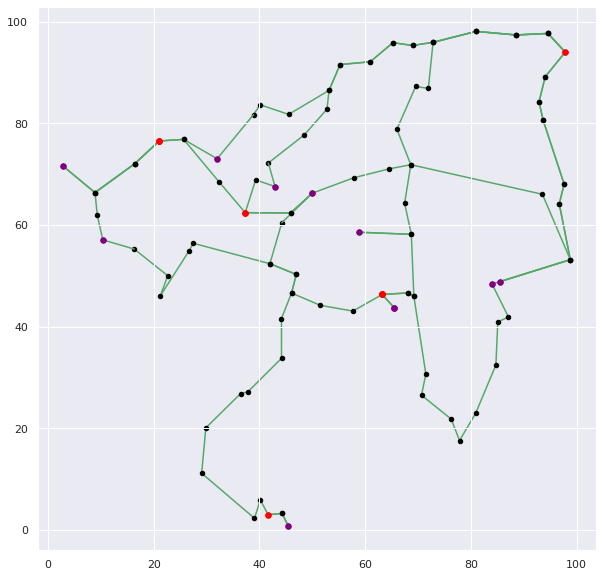

<Figure size 720x720 with 0 Axes>

In [74]:
plt.figure(figsize=(10,10))
routes = {x:{} for x in veiculos.index}  
#Cria novamente as rotas de cada veículo
for i in _Solution3:
        aux = i.split("_")[1:]
        routes[int(aux[2])][int(aux[0])]=int(aux[1])
        
arc_count = {}
ordered_routes_volta={}
for k in atendimentos:
    #Só roda o código se o veículo tiver percorrido pelo menos um arco
    if len(routes[k]) > 0:
        
        
        inicial = atendimentos[k]
        actual_node = routes[k].pop(inicial)
        
        ordered_routes_volta[k]=[inicial]
        
        #Coordenadas X e Y dos pontos que formam o arco
        xcoord=[pontos.loc[inicial]["x"],pontos.loc[actual_node]["x"]]
        ycoord=[pontos.loc[inicial]["y"],pontos.loc[actual_node]["y"]]
        
        #Plotagem gráfica do arco 
        Axes.scatter(xcoord[0],ycoord[0],s=30,color='purple',zorder=1)
        #Axes.text(xcoord[0],ycoord[0],str(inicial),fontsize=12,color="purple")
        Axes.plot(xcoord,ycoord,'g',zorder=0)
        
        #String para plotar o caminho que o carro percorreu
        string=str(k)+": "+str(inicial)+" -> "+str(actual_node)
        
        #Garante que o caminho será plotado mesmo se só tiver um arco
        if len(routes[k]) == 0:
            ordered_routes_volta[k].append(actual_node)
            #Plotagem gráfica do último arco do caminho
            Axes.scatter(xcoord[1],ycoord[1],s=30,color='red',zorder=1)
            #Axes.text(xcoord[1],ycoord[1],str(actual_node),fontsize=12,color="red")
        else:
            while actual_node != alvos[k]:
                ordered_routes_volta[k].append(actual_node)
                next_node = routes[k].pop(actual_node)

                #Adiciona um arco na string
                string+="-> "+str(next_node)

                #Coordenadas X e Y dos pontos que formam o arco
                xcoord=[pontos.loc[actual_node]["x"],pontos.loc[next_node]["x"]]
                ycoord=[pontos.loc[actual_node]["y"],pontos.loc[next_node]["y"]]
                
                #Plotagem gráfica do arco 
                Axes.scatter(xcoord[0],ycoord[0],s=20,color='black',zorder=0)
                Axes.plot(xcoord,ycoord,'g',zorder=-1)
                
                actual_node=next_node
            
            #Plotagem gráfica do último arco do caminho
            Axes.scatter(xcoord[1],ycoord[1],s=20,color='red',zorder=1)
            #Axes.text(xcoord[1],ycoord[1],str(next_node),fontsize=12,color='red')
            
        print(string)
        
Figure

In [75]:
menor_instante=99999
for k in atendimento_instantes:
    tempo_servico = np.random.randint(1,10)
    atendimento_instantes[k]+=tempo_servico
    
    if atendimento_instantes[k] < menor_instante:
        menor_instante = atendimento_instantes[k]

# Sinais Volta

In [76]:
sinais_volta = Model("SinaisVolta")

In [77]:
arc_count = mt.makeArcCount(ordered_routes_volta,_DistanceMatrix) #Arcos usados na solução e a quantidade de usos

In [78]:
#Maior Instante em todos os cenários
#Usado para criar apenas a quantidade
#necessária de variáveis sem desperdiçar memória
maior_instante = 0

#Matriz contendo todas as configurações
#de sinais para cada veículo e sua rota
matriz_rotas2={k:[] for k in atendimentos}


for k in atendimentos:
    #
    #
    #                                        Nodo da 
    #                         Nodos de        vítima        pd.Series
    #           Prioridade    todas as       atendida    com a prioridade
    #            em si        vítimas         por 'k'       da vítima
    #             |              |              |              | 
    #             v              v              v              v           
    prioridade=vitimas[vitimas["Ponto"]==atendimentos[k]]["Prioridade"].values[0]
    
    matriz,instante=mt.buildSets(_DistanceMatrix,                   #Matriz de Distância
                                 ordered_routes_volta[k],          #Rotas por veículo
                                 sinal,                            #Tempo de alteração do sinal
                                 prioridade,                       #Prioridade da vítima atendida por 'k'
                                 pontos,                           #DataFrame com os pontos e arcos
                                 estado,                           #DataFrame com os estados dos sinais
                                 sinais_fixos,                     #Arcos já fixados anteriormente
                                 instante=atendimento_instantes[k],#Instante de Saída da Vítima
                                 sinais_alterados=[],              #Uso interno, instanciar como lista vazia
                                 matriz_sinais=[])                 #Uso interno, instanciar como lista vazia
    #Guarda o maior instante
    #encontrado até o momento
    if instante>maior_instante:
        maior_instante=instante
    
    #Adiciona as configurações
    #possíveis para a rota do
    #veículo 'k' para a matriz
    matriz_rotas2[k] = matriz

In [79]:
#Dicionário para guardar os
#veículos que passam no mesmo
#arco no mesmo instante
same_instant={}

for arc in arc_count:
    #Adiciona o arco atual
    #no dicionário
    same_instant[arc]={}
    
    #Dicionário de instantes
    #separado por veículo
    instants={}
    for k in atendimentos:
        #                         Índice
        #                      da configuração
        #                             |
        #                             |  Arcos percorridos
        # (x,y)              Veículo  |   por 'k'
        #   |                   |    /  _____|______
        #   v                   v   v |            |
        if arc in matriz_rotas2[k][0]["sinais"].keys():#'k' passa em (x,y)?
            #Contador do índice das
            #configurações dos sinais
            count = 0
            
            #Variedade de instantes
            #em que 'k' pode passar
            #em (x,y) de acordo com
            #a configuração que o 
            #modelo escolher
            instants[arc]=[]
            
            #Percorre todas as configurações
            #de sinais para a rota de 'k'
            while count < len(matriz_rotas2[k]):
                #                         Índice da           Instante
                #                        Configuração             |
                #                             |  Configuração     |
                #                     Veículo |       |     (x,y) |
                #                        |    |       |       |   |
                #                        v    v       v       v   v
                instant_k = matriz_rotas2[k][count]["sinais"][arc][1]#Quando 'k' passa em (x,y)?

                #Verificamos se o instante atual ainda não
                #está listado nos instantes em que um dos
                #veículos passa em (x,y)
                if round(instant_k) not in instants[arc]:
                    
                    #Quando for a primeira vez que um veículo
                    #passa em (x,y), adicionamos esse instante
                    #na lista
                    instants[arc].append(round(instant_k))
                    
                    #Quando for a primeira vez que um veículo
                    #passa em (x,y) nesse instante, criamos a
                    #lista no nosso dicionário, usamos o instante
                    #arredondado para baixo como chave e uma tupla
                    #(Veículo,ìndice da Configuração) como valor
                    same_instant[arc][round(instant_k)]=[(k,count)]
                    
                else:
                    #Quando uma nova configuração for encontrada na qual
                    #um veículo passe em (x,y) no mesmo instante, adicionamos
                    #a tupla (Veículo,ìndice da Configuração) no dicionário
                    same_instant[arc][round(instant_k)].append((k,count))
                    #NOTA IMPORTANTE:
                    #
                    #Arredondamos o instante para o inteiro
                    #mais próximo para evitar inconsistências.
                    #Uma vez que se ambos estiverem no arco durante
                    #o mesmo intervalo, os dois se beneficiarão da
                    #alteração ou não alteração do sinal.
                    #
                    #Por exemplo:
                    #   Veículo1 está em (x,y) no instante 7.2
                    #   Veículo2 está em (x,y) no instante 7.31
                    #
                    #      7.2                     7.31
                    #   instante_k Veículo1 != instante_k Veículo2
                    #
                    #           7                           7
                    #    _______|______              _______|______
                    #   |              |            |              |   
                    #   round(instant_k) Veículo == round(instant_k) Veículo2
                count+=1

In [80]:
#Dicionário onde guardaremos
#todas as variáveis do modelo
config = {}

#Nos preocupamos apenas com os
#veículos que saíram para realizar 
#algum atendimento
for k in atendimentos:
    
    #Contador do índice
    #das configurações
    count=0
    
    #Lista das possíveis configurações
    #de sinais para o veículo 'k'
    config[k]=[]
    
    for i in matriz_rotas2[k]:
        #                                                         Índice           Veículo    Peso da Configuração
        #                                                           |                 |                | 
        #                                                           v                 v                v 
        config[k].append({"Config":sinais_volta.binary_var("Config_"+str(count)+"_Carro_"+str(k)),"Peso":i["peso"]})
        #"Config":Variável de Decisão que representa uma configuração completa
        #"Peso": Tempo de percorrer a rota com essa configuração de sinais
        count+=1

In [81]:
#Função Objetivo
minimize=LinearExpr(sinais_volta)

for k in atendimentos:
    #Restrição de unicidade
    choose1=LinearExpr(sinais_volta)
    
    for i in config[k]:
        #Adiciona a configuração 
        #atual à restrição
        choose1+=i["Config"]
        
        #Adiciona o peso da configuração
        #na função objetivida para ser
        #minimizado futuramente
        minimize+=i["Config"]*i["Peso"]
        
    #Permitimos ao modelo escolher
    #apenas uma configuração para
    #cada rota percorrida
    sinais_volta.add_constraint(choose1==1,"Choose1ConfigVehicle"+str(k))
    
sinais_volta.minimize(minimize)

In [82]:
#Varremos todos os arcos
#no nosso dicionário
for arc in same_instant:
    
    #Precisamos verificar todos os
    #instantes em que um veículo
    #passou por esse arco
    for instant in same_instant[arc]:
        
        #Dicionário que irá conter
        #todas as expressões de
        #consistência que iremos criar
        expressions={}
        
        for i in same_instant[arc][instant]:
            #i=(Veículo,Índice da Configuração)
            vehicle = i[0]
            config_number = i[1]
            
            #Verificamos se o veículo atual
            #não está entre as chaves do nosso
            #dicionário de expressões
            if vehicle not in expressions.keys():
                #Criamos a expressão linear
                #que será usada como restrição
                expr=LinearExpr(sinais_volta)
                
                #Inicializamos ela com a configuração atual
                expr+=config[vehicle][config_number]["Config"]
                
                #Instanciamos a chave no dicionário
                expressions[vehicle]=expr
            else:
                #Adicionaremos todas as configurações
                #do veículo 'k' que passam em (x,y)
                #no mesmo instante
                expressions[vehicle]+=config[vehicle][config_number]["Config"]
        
        #Restrição de Consistência
        consistent_timing=LinearExpr(sinais_volta)
        #Contador Auxiliar
        count=0
        for k in expressions:
            #Consideramos o primeiro veículo como o pivô
            if count==0:
                #Todas as configurações dele são multiplicadas
                #pela quantidade de OUTROS veículos no dicionário
                consistent_timing+=(len(expressions)-1)*expressions[k]
                count+=1
            else:
                #Caso não seja nosso veículo pivô, subtraímos
                #a configuração da nossa expressão
                consistent_timing-=expressions[k]
        
        #A expressão é construída dessa forma pois,
        #caso alguma das configurações seja escolhida,
        #nós forçamos que todas as outras também o sejam
        #e, caso nenhuma seja escolhida, que nenhuma das
        #outras também o seja
        #Exemplo:
        #    k=Veículo Pivô a=b= Outros Veículos
        #   
        #    expr=2*k_0 + 2*k_1...+2*k_m 
        #         - a_0 - a_1 -...a_n
        #         - b_0 - b_1 -...b_o
        #
        #    Se k_0 = 1 e expr==0, Então:           _
        #         - a_0 - a_1 -...a_n = -1 |-Só pode escolher 
        #         - b_0 - b_1 -...b_o = -1_| uma configuração
        #
        #    Se 2*k_0 + 2*k_1...+2*k_m = 0 e expr == 0, Então
        #         - a_0 - a_1 -...a_n = 0
        #         - b_0 - b_1 -...b_o = 0
        sinais_volta.add_constraint(consistent_timing==0,"ConsistentTimingArc_"+str(arc)+"_instant_"+str(instant))

In [83]:
_Solution4 = sinais_volta.solve()

In [84]:
tempo_total_volta=0
tempo_cru_volta=0
relativo_volta=0
tempo_veiculos_volta = {k:{"total":0,"cru":0} for k in atendimentos}

#O código abaixo serve apenas para imprimir
#a solução em uma espécie de texto formatado
#e fixar os sinais da solução atual
for i in _Solution4.as_dict():
    carro = int(i.split("_")[3])
    config = int(i.split("_")[1])
    string1="Veículo"+str(carro)
    string2="(Sit,T)"+" "*(len(string1)-4)
    
    tempo_total_volta+=matriz_rotas2[carro][config]["tempo"]
    tempo_cru_volta+=matriz_rotas2[carro][0]["tempo"]
    relativo_volta+=matriz_rotas2[carro][config]["relativo"]
    
    tempo_veiculos_volta[carro]["total"]=matriz_rotas2[carro][config]["tempo"]
    tempo_veiculos_volta[carro]["cru"]=matriz_rotas2[carro][0]["tempo"]
    
    for i in matriz_rotas2[int(carro)][int(config)]["sinais"]:
        string1+= "-> "+str(i)
        
        alterado=matriz_rotas2[carro][config]["sinais"][i][0]
        instante=round(matriz_rotas2[carro][config]["sinais"][i][1])
        string2+=str((alterado,instante))+" "*(len(str(i))-3)
    print(string1)
    print(string2)
    print("")

Veículo3-> (134, 85)-> (85, 125)-> (125, 157)-> (157, 129)-> (129, 150)-> (150, 61)
(Sit,T)    (0, 15)      (0, 16)      (0, 17)       (0, 18)       (0, 18)       (0, 19)      

Veículo7-> (28, 101)-> (101, 67)-> (67, 181)-> (181, 83)-> (83, 178)-> (178, 81)-> (81, 174)-> (174, 58)-> (58, 118)-> (118, 66)-> (66, 98)-> (98, 16)
(Sit,T)    (0, 9)      (0, 9)      (0, 10)      (1, 12)      (0, 12)      (0, 13)      (1, 14)      (0, 15)      (1, 16)      (1, 18)      (1, 20)     (0, 20)     

Veículo9-> (51, 92)
(Sit,T)    (0, 2)     

Veículo11-> (193, 102)
(Sit,T)     (1, 6)       

Veículo13-> (41, 0)-> (0, 13)-> (13, 64)-> (64, 83)-> (83, 178)-> (178, 81)-> (81, 174)-> (174, 58)-> (58, 118)-> (118, 66)-> (66, 98)-> (98, 16)
(Sit,T)     (0, 6)    (1, 8)    (0, 9)     (1, 10)     (0, 11)      (0, 11)      (1, 13)      (0, 13)      (1, 15)      (1, 17)      (1, 18)     (0, 19)     

Veículo19-> (53, 12)-> (12, 112)-> (112, 120)-> (120, 114)-> (114, 124)-> (124, 199)-> (199, 106)-> (106, 5

# Tempos

In [85]:
tempos = pd.read_csv("tempos.csv",index_col=0)

In [86]:
menor_tempo=99999
maior_tempo=0
media = 0
for k in atendimentos:
    percursso = tempo_veiculos_ida[k]["total"]+tempo_veiculos_volta[k]["total"]
    media += tempo_veiculos_ida[k]["cru"]+tempo_veiculos_volta[k]["cru"]
    media -= tempo_veiculos_ida[k]["total"]+tempo_veiculos_volta[k]["total"]
    if percursso<menor_tempo:
        menor_tempo=percursso
    if percursso>maior_tempo:
        maior_tempo=percursso
media/=k

In [87]:
tempo_total_viagem=tempo_total_ida+tempo_total_volta
tempo_cru_viagem=tempo_cru_ida+tempo_cru_volta
relativo_total = relativo_ida+relativo_volta

In [88]:
economia=tempo_total_viagem/tempo_cru_viagem

In [89]:
relativo=relativo_total/tempo_cru_viagem

In [90]:
total=(tempo_total_viagem+relativo_total)/tempo_cru_viagem

In [91]:
tempos=tempos.append({"RazaoEconomia":economia,
               "RazaoRelativo":relativo,
               "RazaoTotal":total,
               "TempoMedio":media,
               "MenorTempo":menor_tempo,
               "MaiorTempo":maior_tempo},ignore_index=True)

In [92]:
tempos.to_csv("tempos.csv")

# Apresentação

In [93]:
tvi=pd.DataFrame(columns=["carro","total","cru"])

In [94]:
for k in tempo_veiculos_ida:
    total=tempo_veiculos_ida[k]["total"]
    cru = tempo_veiculos_ida[k]["cru"]
    aux1= {"carro":k,"total":total,"Cru":0}
    aux2= {"carro":k,"total":cru,"Cru":1}
    tvi=tvi.append(pd.DataFrame(aux1,index=[0]),ignore_index=True)
    tvi=tvi.append(pd.DataFrame(aux2,index=[0]),ignore_index=True)
    

Text(0.5, 0, 'Veículos')

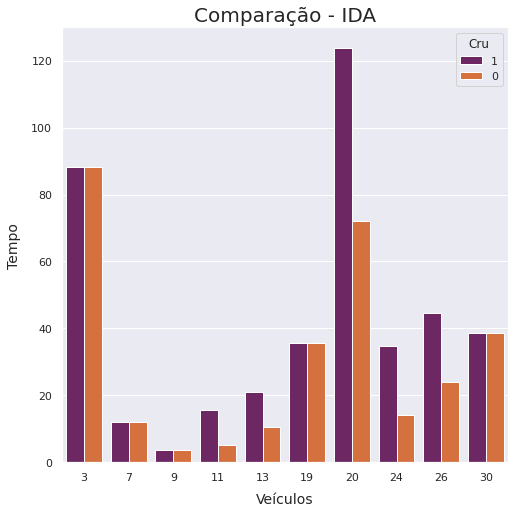

In [95]:
#Create the plot 
Figure, Axes = plt.subplots(figsize=(8,8))

bar = sns.barplot(x="carro",y="total",hue="Cru",hue_order=[1,0],data=tvi,palette="inferno")
#Additional parameters
Axes.set_title("Comparação - IDA",fontsize=20)
Axes.set_ylabel("Tempo",labelpad=10,fontsize=14)
Axes.set_xlabel("Veículos",labelpad=10,fontsize=14)

In [96]:
tvv = pd.DataFrame(columns=["carro","total","cru"])

In [97]:
for k in tempo_veiculos_volta:
    total=tempo_veiculos_volta[k]["total"]
    cru = tempo_veiculos_volta[k]["cru"]
    aux1= {"carro":k,"total":total,"Cru":0}
    aux2= {"carro":k,"total":cru,"Cru":1}
    tvv=tvv.append(pd.DataFrame(aux1,index=[0]),ignore_index=True)
    tvv=tvv.append(pd.DataFrame(aux2,index=[0]),ignore_index=True)

Text(0.5, 0, 'Veículos')

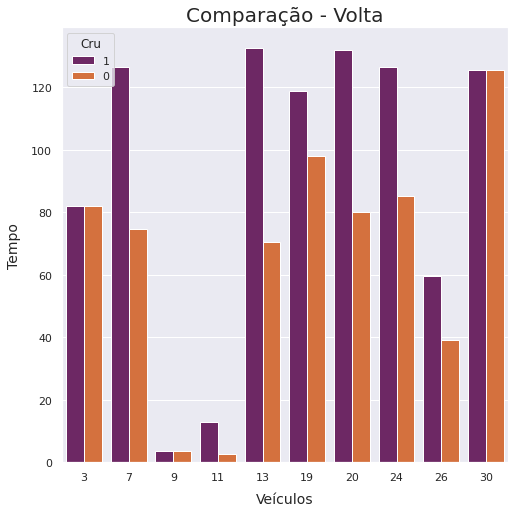

In [98]:
#Create the plot 
Figure, Axes = plt.subplots(figsize=(8,8))

bar = sns.barplot(x="carro",y="total",hue="Cru",hue_order=[1,0],data=tvv,palette="inferno")
#Additional parameters
Axes.set_title("Comparação - Volta",fontsize=20)
Axes.set_ylabel("Tempo",labelpad=10,fontsize=14)
Axes.set_xlabel("Veículos",labelpad=10,fontsize=14)

In [110]:
sum(tempos["RazaoTotal"])/6

0.7887335638313923

In [102]:
tempos

,RazaoEconomia,RazaoRelativo,RazaoTotal,TempoMedio,MaiorTempo,MenorTempo
0,0.630555,0.149980,0.780535,14.710154,194.853230,7.932602
1,0.600752,0.161556,0.762308,25.376563,206.150569,68.672015
2,0.636058,0.183522,0.819580,21.502849,218.458672,53.280267
3,0.633105,0.163259,0.796363,18.577176,209.962322,4.595769
4,0.649718,0.131033,0.780750,15.480980,190.982500,13.186695
5,0.722828,0.070037,0.792865,12.384784,170.316707,7.094399
